# Stock Analysis

## 1.1 Project Objective

The objective of this project is to assist our investment firm in identifying high-potential indexes for short-term investment. By analyzing historical stock data and forecasting future returns, we aim to determine which indexes are most likely to yield favorable returns within a specified period. Additionally, we will assess the associated risks and volatilities of these indexes to guide a balanced investment decision. Our final deliverables include forecasted returns, volatility insights, and strategic recommendations for index fund selection.

## 1.2 Motivation

Index funds offer a diversified, cost-effective way to gain exposure to market segments, making them an attractive option for institutional investors. However, selecting the right index requires a balance between potential returns and risk tolerance. This project focuses on providing short-term forecasts for several indexes, along with a comprehensive risk assessment, allowing our firm to capitalize on promising market trends while maintaining prudent risk management. By presenting these findings in an accessible format, we aim to support informed decision-making across the firm.

## Step 2: Data Preparation and Exploration
**2.1 Load the Data**

In [28]:
# Import libraries
import pandas as pd
import numpy as np

from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load the Dataset
df = pd.read_csv('data\stock_data.csv')

# Display basic information
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104224 entries, 0 to 104223
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Index      104224 non-null  object 
 1   Date       104224 non-null  object 
 2   Open       104224 non-null  float64
 3   High       104224 non-null  float64
 4   Low        104224 non-null  float64
 5   Close      104224 non-null  float64
 6   Adj Close  104224 non-null  float64
 7   Volume     104224 non-null  float64
 8   CloseUSD   104224 non-null  float64
dtypes: float64(7), object(2)
memory usage: 7.2+ MB
None


,Index,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD
0,HSI,1986-12-31,2568.300049,2568.300049,2568.300049,2568.300049,2568.300049,0.0,333.879006
1,HSI,1987-01-02,2540.100098,2540.100098,2540.100098,2540.100098,2540.100098,0.0,330.213013
2,HSI,1987-01-05,2552.399902,2552.399902,2552.399902,2552.399902,2552.399902,0.0,331.811987
3,HSI,1987-01-06,2583.899902,2583.899902,2583.899902,2583.899902,2583.899902,0.0,335.906987
4,HSI,1987-01-07,2607.100098,2607.100098,2607.100098,2607.100098,2607.100098,0.0,338.923013


**2.2 Data Cleaning**

Let's handle incorrect dtypes, missing values, any duplicates in the data to avoid skewing analysis

In [4]:
# Convert Date to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Check for missing values
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values)

# Drop duplicates if any
df = df.drop_duplicates()
# df.shape There's no change in shape

Missing values:
 Index        0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
CloseUSD     0
dtype: int64


**2.3 Basic Data Exploration**

In [5]:
print('List of Indexes: ', df['Index'].unique())
print('-'*55)
# Check the date range
print("Date range:", df['Date'].min(), "to", df['Date'].max())
print('-'*55)
# Calculate daily returns
df['Daily_Return'] = df.groupby('Index')['Close'].pct_change()
# Summary statistics
df.describe()

List of Indexes:  ['HSI' 'NYA' 'IXIC' '000001.SS' 'N225' 'N100' '399001.SZ' 'GSPTSE' 'NSEI'
 'GDAXI' 'SSMI' 'TWII' 'J203.JO']
-------------------------------------------------------
Date range: 1965-01-05 00:00:00 to 2021-06-03 00:00:00
-------------------------------------------------------


,Open,High,Low,Close,Adj Close,Volume,CloseUSD,Daily_Return
count,104224.000000,104224.000000,104224.000000,104224.000000,104224.000000,1.042240e+05,104224.000000,104211.000000
mean,8015.353334,8063.324234,7962.581120,8014.366642,8014.161269,1.347646e+09,3046.729177,0.000339
std,9140.563404,9196.575802,9082.767802,9140.609758,9140.720456,4.427662e+09,3747.865623,0.013046
min,54.869999,54.869999,54.869999,54.869999,54.869999,0.000000e+00,10.204900,-0.333304
25%,2046.887756,2057.213990,2037.185943,2047.506470,2047.358490,0.000000e+00,320.460898,-0.005297
50%,5772.140137,5812.764892,5725.199951,5773.710205,5773.710205,9.529000e+05,1371.598486,0.000630
75%,10487.377445,10552.179690,10416.092287,10488.622560,10488.622560,2.064676e+08,4383.045241,0.006354
max,68775.062500,69403.750000,68516.992190,68775.062500,68775.062500,9.440374e+10,18934.376173,0.188236


**2.4 Exploration Data Analysis**

Let's explore a few aspects of our stock to get more insights of the indexes we have. Focus will be on these key areas:

- **Average Returns**: Let's calculate the mean daily return for each index to indentify those with higher average performance historically
- **Annualized Volatility**: Calculate volatility to understand the indexes that have been more or less stable over time
- **Visualization**:Visualize daily closing prices for a few indexes to observe general trends over time

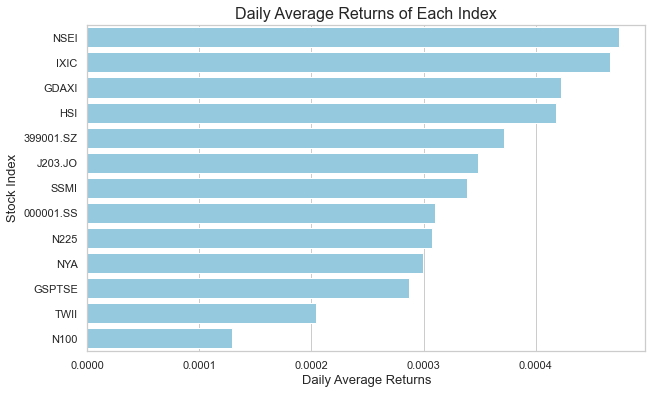

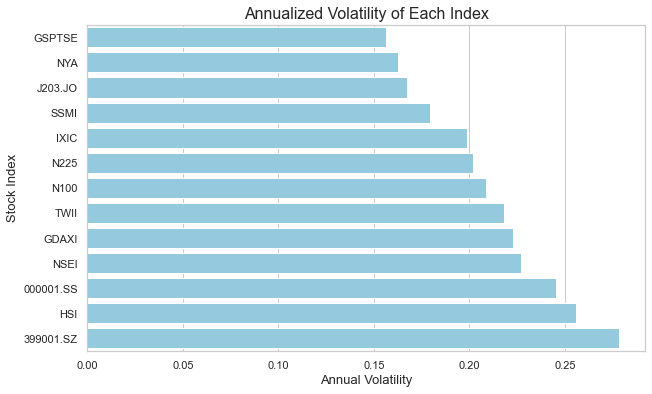

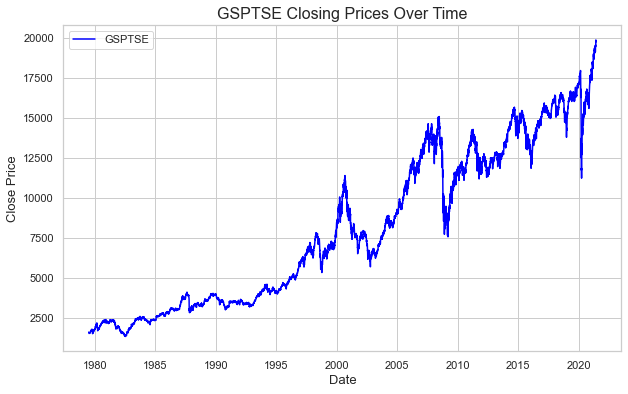

In [6]:
# 1. Daily Returns
# Average daily return for each index
average_returns = df.groupby('Index')['Daily_Return'].mean()
# Sort values
average_returns = average_returns.sort_values(ascending=False)

# Plot Daily Avg returns using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=average_returns.values, y=average_returns.index, color='skyblue')
plt.title('Daily Average Returns of Each Index', fontsize=16)
plt.xlabel('Daily Average Returns', fontsize=13)
plt.ylabel('Stock Index', fontsize=13)
plt.show()

# 2. Volatility
# Calculate annualized volatility (assuming ~252 trading days in a year)
annual_volatility = df.groupby('Index')['Daily_Return'].std() * np.sqrt(252)
# Sort values
annual_volatility = annual_volatility.sort_values(ascending=True)

# Plot volatility comparison using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=annual_volatility.values, y=annual_volatility.index, color='skyblue')
plt.title('Annualized Volatility of Each Index', fontsize=16)
plt.xlabel('Annual Volatility', fontsize=13)
plt.ylabel('Stock Index', fontsize=13)
plt.show()

# 3. Closing Prices
# Closing prices of a specific index over time
# Filter for an index
stock_index = df[df['Index'] == 'GSPTSE']

# Plot closing prices over time using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Close', data=stock_index, label="GSPTSE", color="blue")
plt.title("GSPTSE Closing Prices Over Time", fontsize=16)
plt.xlabel("Date", fontsize=13)
plt.ylabel("Close Price", fontsize=13)
plt.legend()
plt.show()

**2.5 Selecting Promising Indexes**

We'll use the `average daily returns` and `annualized volatility` calculated above to identify indexes with promising returns and acceptable levels of risk then create a shortlist of 3-5 indexes with favorable performance metrics to focus on in forecasting.

In [7]:
# Combining returns and volatility into a single DataFrame
performance_metrics = pd.DataFrame({
    'Average_Return': average_returns,
    'Annual_Volatility': annual_volatility
})
# # Display the indexes sorted by Average Return
# print("Indexes sorted by average return:\n", performance_metrics.sort_values(by="Average_Return", ascending=False))

# Shortlist top indexes based on return and volatility criteria
top_indexes = performance_metrics.nlargest(5, 'Average_Return')
print("Top indexes based on returns and volatility:\n", top_indexes)


Top indexes based on returns and volatility:
            Average_Return  Annual_Volatility
NSEI             0.000474           0.227180
IXIC             0.000467           0.198867
GDAXI            0.000423           0.223143
HSI              0.000419           0.256077
399001.SZ        0.000372           0.278256


**Summary of Findings and Preparation for Next Steps**
- Based on the historical data, `NSEI` and `IXIC` yielded the highest daily average returns.
- `GSPTSE` and `NYA` were the most stable stock over the years showing the least annual volatility rate
- Despite `399001.SZ` being among the best (5th) performing indexes in term of daily average returns, it's the most unstable stock with the highest annual volatility rate
- Our candidates for short-term forecasting in the next steps will be: `NSEI, IXIC, GDAXI, HSI, 39001.SZ`

With our shortlist of promising indexes, we can now move into forecasting, where we’ll project short-term returns for these specific indexes.

## Step 3. Forecasting Approach
**3.1 Forecasting Objective**

Our goal is to create a short-term forecasts of daily returns or closing prices for the promising indexes.

Forecasting horizon will be 30 days, as specified by the firm's interest in short-term predictions

For simplicity and intepretability, our model of choice will be ARIMA (Auto-Regressive Integrated Moving Average) which is well-suited for time series and can provide short-term forecasts

**3.2 Prepare Data for Forecasting (Stationarity check)**

Let's start with one of the promising indexes and filter data then perform a stationarity check with Augmented Dickey-Fuller which is required for ARIMA models and, if needed, apply transformations to make the data stationary. If p-value < 0.05, the series is stationary, otherwise we may need to difference.

In [8]:
# Filter data for a single index
index_data = df[df['Index'] == 'IXIC']

# Check for stationarity with the ADF test on the closing price
result = adfuller(index_data['Close'].dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: 5.226063217091626
p-value: 1.0


With an ADF statistic of 0.619 and a p-value of 0.988, the data is `non-stationary`. This high p-value (greater than 0.05) suggests that we fail to reject the null hypothesis of the ADF test, meaning the series likely has a trend or other non-stationary patterns.

For non-stationary data, a common solution is differencing the series to make it stationary. Differencing (i.e., subtract each observation from the previous one) removes trends and helps stabilize the mean of the time series.

Let's go ahead and apply differencing and check for stationarity again

**3.2.1 Verify Stationarity After Differencing**

In [9]:
# First differencing
df['Close_Diff'] = df.groupby('Index')['Close'].diff()

# Filter data for the index you're analyzing,
index_data_diff = df[df['Index'] == 'IXIC']['Close_Diff'].dropna()

# ADF test on differenced data
result_diff = adfuller(index_data_diff)
print("ADF Statistic (Differenced):", result_diff[0])
print("p-value (Differenced):", result_diff[1])

# Interpretation: If p-value < 0.05, the differenced series is stationary.

ADF Statistic (Differenced): -16.762101301639316
p-value (Differenced): 1.3076139989278008e-29


We won't be differencing our data any further as we can see our p-value is less than 0.05 already implying our data is now stationary and we can proceed to the use it in the ARIMA model

**3.3 Model Selection and Parameter Tuning**

We'll use the auto_arima function to automatically select the best parameters for the ARIMA model (i.e., the values of p, d, and q). Since we have already differenced the series (making d=1), we only need to find the optimal p and q parameter where:
- p is the order of the autoregressive term
- q is the order of the moving average term
- d is degree of differencing, which is 1 here

In [22]:
# Apply auto_arima to the differenced data to select p and q
model = pm.auto_arima(index_data_diff, seasonal=False, trace=True, suppress_warnings=True, n_jobs=-1, max_p=5, max_q=5, d=1)

# Print the optimal parameters found
print(f"Optimal ARIMA Model order: {model.summary()}")

# Get the optimal p, d, q values
p, d, q = model.order
print(f"Optimal parameters: p={p}, d={d}, q={q}")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=42.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=143234.163, Time=0.48 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=137946.210, Time=0.97 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=11.84 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=143232.163, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=136391.080, Time=1.31 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=135622.706, Time=1.83 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=135084.272, Time=2.41 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=134974.004, Time=2.95 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=25.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=28.54 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=134972.004, Time=1.27 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=135082.273, Time=1.91 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=19.68 sec
 ARIMA(4,1,1)(0,0,0)[0]            

**3.4: Rolling Backtesting for Evaluation**

We'll use 100 observations for rolling_window_size to train the model. Forecast one period ahead, then shift the window by one observation and repeat.
This iterative approach provides a better understanding of model performance over multiple points.

In [24]:
print(f"Using ARIMA parameters: p={p}, d={d}, q={q}")

# Define your rolling window size and forecast horizon
rolling_window_size = 100  # Example, adjust based on your dataset
forecast_horizon = 1  # Example, forecasting 1 step ahead for simplicity

# Create lists to store forecast and actual results
forecast_results = []
actual_results = []

# Loop through the data for rolling window
for start in range(len(index_data_diff) - rolling_window_size - forecast_horizon + 1):
    # Define rolling window and test point
    train_window = index_data_diff.iloc[start:start + rolling_window_size]
    test_point = index_data_diff.iloc[start + rolling_window_size]
    
    # Fit ARIMA to the rolling window using the fixed p, d, q
    model = ARIMA(train_window, order=(p, d, q))  # d=1 because we differenced once
    fitted_model = model.fit()
    
    # Forecast one step ahead
    forecast = fitted_model.forecast(steps=forecast_horizon)
    
    # Ensure forecast is an array or Series and extract the first value
    forecast_value = forecast[0] if isinstance(forecast, np.ndarray) else forecast.iloc[0]
    
    # Append forecasted and actual values
    forecast_results.append(forecast_value)
    actual_results.append(test_point)

# Convert results to Series for easier comparison
forecast_series = pd.Series(forecast_results, index=index_data_diff.iloc[rolling_window_size:].index)
actual_series = pd.Series(actual_results, index=index_data_diff.iloc[rolling_window_size:].index)

# Calculate and print Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_series, forecast_series)
print(f"Mean Absolute Error (MAE): {mae}")

Using ARIMA parameters: p=5, d=1, q=0
Mean Absolute Error (MAE): 21.84613141211075


In [41]:
# Calculate and print Mean Squared Error (MSE)
mse = mean_squared_error(actual_series, forecast_series)
print(f"Mean Squared Error (MSE): {mse}")
epsilon = 1e-10  # Small constant to avoid division by zero
mape = np.mean(np.abs((forecast_series - actual_series) / (actual_series + epsilon))) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
rmse = np.sqrt(mean_squared_error(actual_series, forecast_series))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Squared Error (MSE): 2704.6207026238285
Mean Absolute Percentage Error (MAPE): 3712819194.5346107%
Root Mean Squared Error (RMSE): 52.005967951994016


- On average, my model's forecasts are off by about 21.846 units from the actual values. Whether this is good or bad depends on the context of your data. If your stock index values range widely, this could be an acceptable error, but if your values are relatively small, it might signal room for improvement
- MSE penalizes large errors more heavily than MAE due to squaring the error term. The value here is quite large, indicating that there are some significant deviations in your predictions, possibly due to outliers or large errors in a few points.
- The MAPE value is extremely high, indicating a severe issue. Typically, a percentage error of such magnitude can be caused by several factors:

   * Very large actual values or extreme outliers.
   * Zero or near-zero values in the denominator (actual values) that cause division by zero or near-zero values.
   * Transformation issues, using differenced data with original data
- RMSE is sensitive to large errors and is often more useful when large deviations matter. A value of 52.01 suggests that there is some substantial error in the predictions. Since it’s derived from the MSE, it confirms that there are a few large errors in the model.

**3.5: Visualize Forecasting Results**

Create a plot to compare your rolling forecast against the actual differenced values.

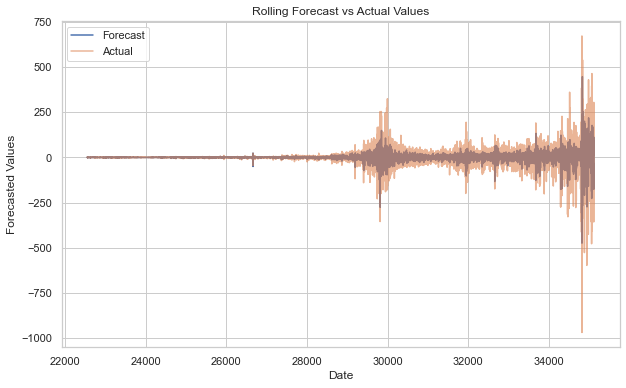

In [36]:
# Plot the forecast vs actual values
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(forecast_series, label="Forecast")
plt.plot(actual_series, label="Actual", alpha=0.6)
plt.title("Rolling Forecast vs Actual Values")
plt.xlabel("Date")
plt.ylabel("Forecasted Values")
plt.legend()
plt.show()

**3.6 Interpret Results and Forecast Performance**

- **Accuracy Evaluation**: Summarize performance metrics like Mean Absolute Error (MAE) or Mean Squared Error (MSE).
- **Insights**: Briefly discuss the forecast accuracy and any patterns you observe in the forecast vs. actual plot.
- **Model Refinement**: If accuracy is unsatisfactory, consider trying other models, re-evaluating parameters, or further optimizing the ARIMA model.

**3.7 Conclusion for Forecasting Step**

Summarize the performance of your model, highlighting whether it provides reliable forecasts. Discuss whether this forecasting model and method might be useful in guiding investment decisions, noting any limitations encountered.
This backtesting-focused approach provides a more reliable model evaluation, reinforcing the credibility of your forecasting insights for investment purposes.